## ECG Anomaly Detection

In [2]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
from tensorflow import set_random_seed
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)


from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

# set random seed
seed(10)
set_random_seed(10)


Using TensorFlow backend.


In [3]:
# set random seed
seed(10)
set_random_seed(10)

# Data loading and pre-processing

In [4]:
# The ECG dataset containing a single anomaly corresponding to a pre-ventricular contraction
# dataset from http://www.cs.ucr.edu/~eamonn/discords/
import pickle
train_data_dir= 'data/ecg/chfdb_chf01_275_train.pkl'
test_data_dir= 'data/ecg/chfdb_chf01_275_test.pkl'
with open(train_data_dir, 'rb') as f:
    train_raw = pickle.load(f)
with open(test_data_dir, 'rb') as f:
    test_raw = pickle.load(f)

In [5]:
#only use target 1 & target 2
train = pd.DataFrame(train_raw,columns=['Target1','Target2','label']).iloc[:,:2]
test = pd.DataFrame(test_raw,columns=['Target1','Target2','label']).iloc[:,:2]

In [6]:
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (1833, 2)
Test dataset shape: (1841, 2)


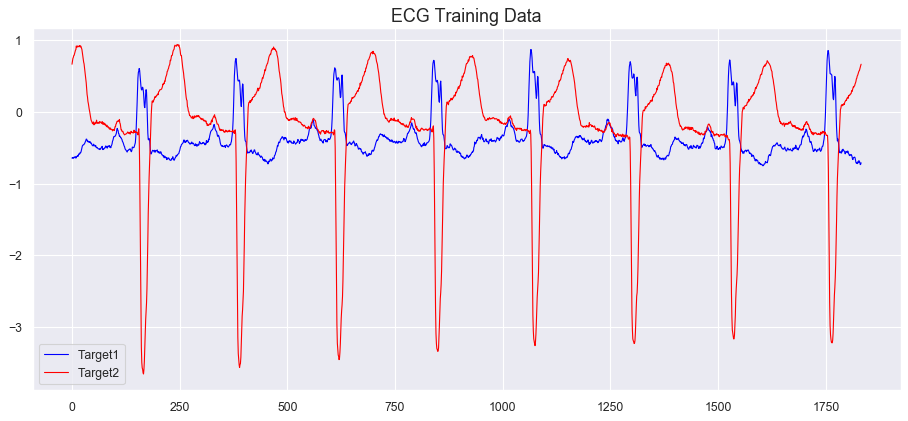

In [7]:
# train data plot
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['Target1'], label='Target1', color='blue', animated = True, linewidth=1)
ax.plot(train['Target2'], label='Target2', color='red', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('ECG Training Data', fontsize=16)
plt.show()

In [8]:
# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "data/ecg/real_scaler_data"
joblib.dump(scaler, scaler_filename)

['data/ecg/real_scaler_data']

In [9]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (1833, 1, 2)
Test data shape: (1841, 1, 2)


In [10]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(24, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(10, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(10, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(24, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [11]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 2)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 24)             2592      
_________________________________________________________________
lstm_2 (LSTM)                (None, 10)                1400      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 10)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 10)             840       
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 24)             3360      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 2)              50        
Total para

In [12]:
# fit the model to the data
nb_epochs = 100
batch_size = 20
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Train on 1741 samples, validate on 92 samples
Epoch 1/100
1741/1741 [==============================] - 3s 2ms/step - loss: 0.4286 - val_loss: 0.3658
Epoch 2/100
1741/1741 [==============================] - 1s 325us/step - loss: 0.2014 - val_loss: 0.1954
Epoch 3/100
1741/1741 [==============================] - 1s 316us/step - loss: 0.0910 - val_loss: 0.1727
Epoch 4/100
1741/1741 [==============================] - 1s 315us/step - loss: 0.0755 - val_loss: 0.1532
Epoch 5/100
1741/1741 [==============================] - 1s 323us/step - loss: 0.0707 - val_loss: 0.1457
Epoch 6/100
1741/1741 [==============================] - 1s 314us/step - loss: 0.0682 - val_loss: 0.1423
Epoch 7/100
1741/1741 [==============================] - 1s 307us/step - loss: 0.0669 - val_loss: 0.1396
Epoch 8/100
1741/1741 [==============================] - 1s 305us/step - loss: 0.0657 - val_loss: 0.1333
Epoch 9/100
1741/1741 [==============================] - 1s 331us/step - loss: 0.0640 - val_loss: 0.1382
Epoch 10/10

1741/1741 [==============================] - 1s 378us/step - loss: 0.0084 - val_loss: 0.0147
Epoch 78/100
1741/1741 [==============================] - 1s 359us/step - loss: 0.0083 - val_loss: 0.0146
Epoch 79/100
1741/1741 [==============================] - 1s 332us/step - loss: 0.0085 - val_loss: 0.0145
Epoch 80/100
1741/1741 [==============================] - 1s 343us/step - loss: 0.0074 - val_loss: 0.0154
Epoch 81/100
1741/1741 [==============================] - 1s 332us/step - loss: 0.0071 - val_loss: 0.0133
Epoch 82/100
1741/1741 [==============================] - 1s 332us/step - loss: 0.0064 - val_loss: 0.0149
Epoch 83/100
1741/1741 [==============================] - 1s 337us/step - loss: 0.0065 - val_loss: 0.0112
Epoch 84/100
1741/1741 [==============================] - 1s 345us/step - loss: 0.0055 - val_loss: 0.0098
Epoch 85/100
1741/1741 [==============================] - 1s 337us/step - loss: 0.0059 - val_loss: 0.0128
Epoch 86/100
1741/1741 [==============================] - 1

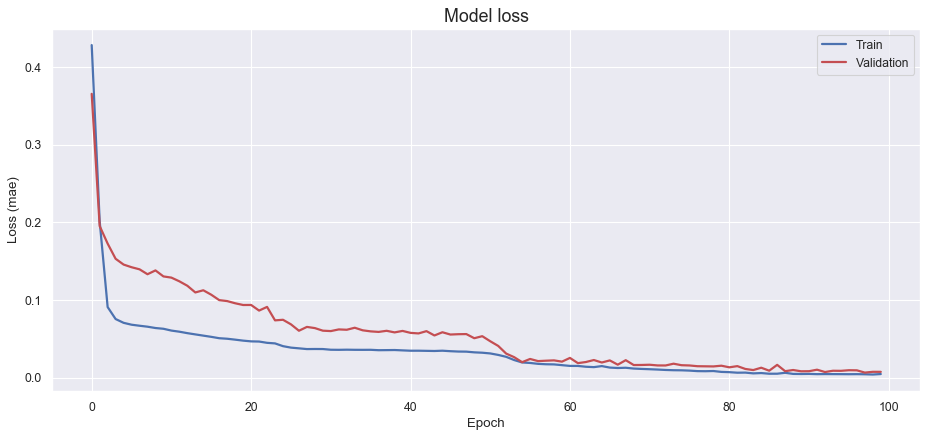

In [13]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

# Distribution of Loss Function

(0.0, 0.1)

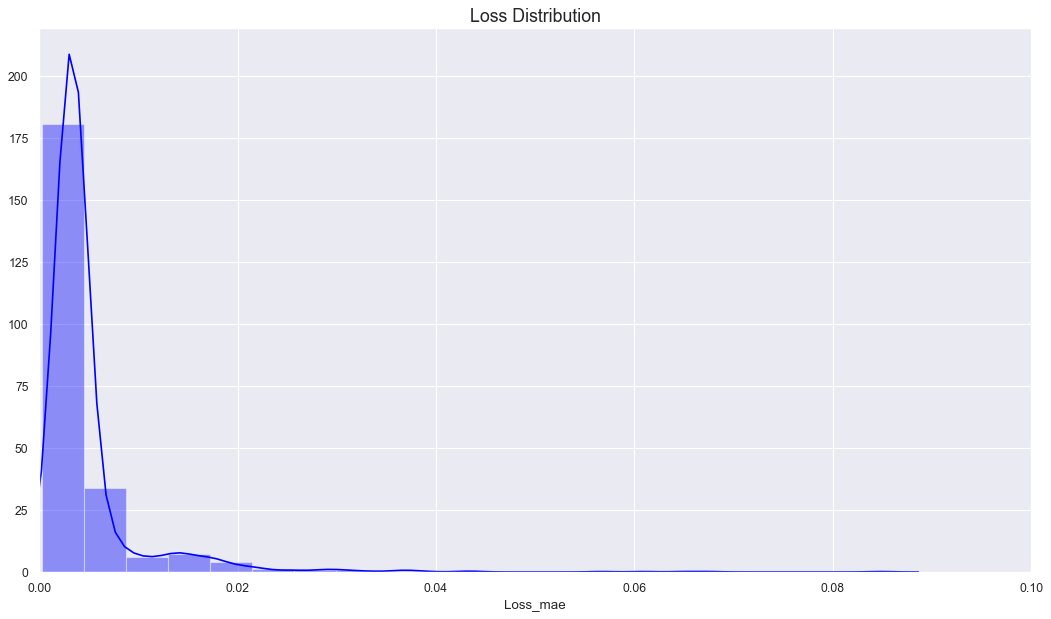

In [14]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,0.1])

In [15]:
# calculate the loss on the test set
print('anomaly threshold = {}'.format(np.percentile(scored,100)))
threshold = np.percentile(scored,100)

X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = threshold
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

anomaly threshold = 0.08487191624428692


,Loss_mae,Threshold,Anomaly
0,0.001363,0.084872,False
1,0.002035,0.084872,False
2,0.002128,0.084872,False
3,0.001701,0.084872,False
4,0.001526,0.084872,False


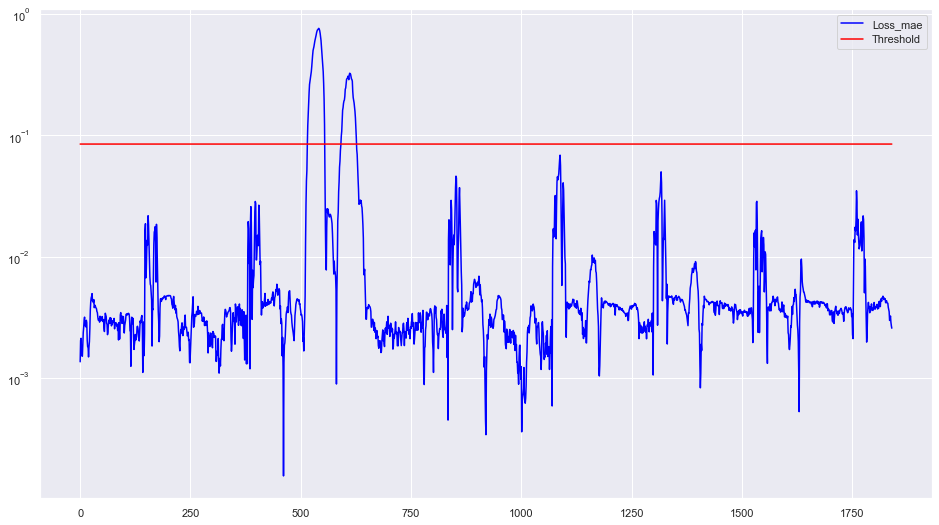

In [16]:
# test set에 대한 결과
scored.plot(logy=True,  figsize=(16,9), ylim=[0,1.10], color=['blue','red'])

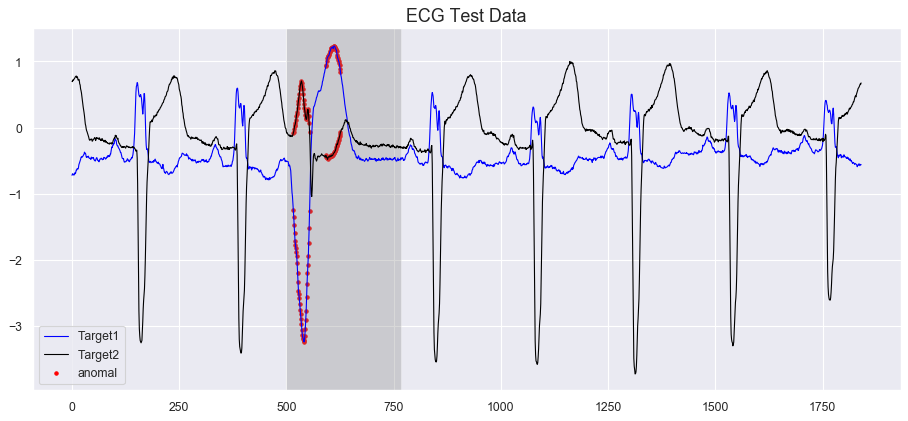

In [17]:
#whole test data
test_ = pd.DataFrame(test_raw,columns=['Target1','Target2','label'])

#make plot
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_['Target1'], label='Target1', color='blue', animated = True, linewidth=1)
ax.scatter(test_[scored['Anomaly']==1]['Target1'].index,test_[scored['Anomaly']==1]['Target1'],label='anomal',marker='.', color='red')
ax.plot(test_['Target2'], label='Target2', color='black', animated = True, linewidth=1)
ax.scatter(test_[scored['Anomaly']==1]['Target2'].index,test_[scored['Anomaly']==1]['Target2'], marker='.', color='red')
plt.legend(loc='lower left')
ax.set_title('ECG Test Data', fontsize=16)
plt.axvspan(min(test_[test_['label']==1].index), max(test_[test_['label']==1].index), facecolor='gray', alpha=0.3)

plt.show()

In [18]:
# save all model information, including weights, in h5 format
model.save("ecg_model.h5")
print("Model saved")

Model saved
